In [ ]:
!pip insta  mplcyberpunk

In [37]:
import torch
import torchvision

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn

In [3]:
# check the version of torch and torchvision
print(torch.__version__, torchvision.__version__)

# setup device agnoustic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.8.0+cu126 0.23.0+cu126
cpu


### Loading, Exploring and Preparing the dataset

we are going to use FashionMNIST Dataset from torch vision

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 225kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.19MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.60MB/s]


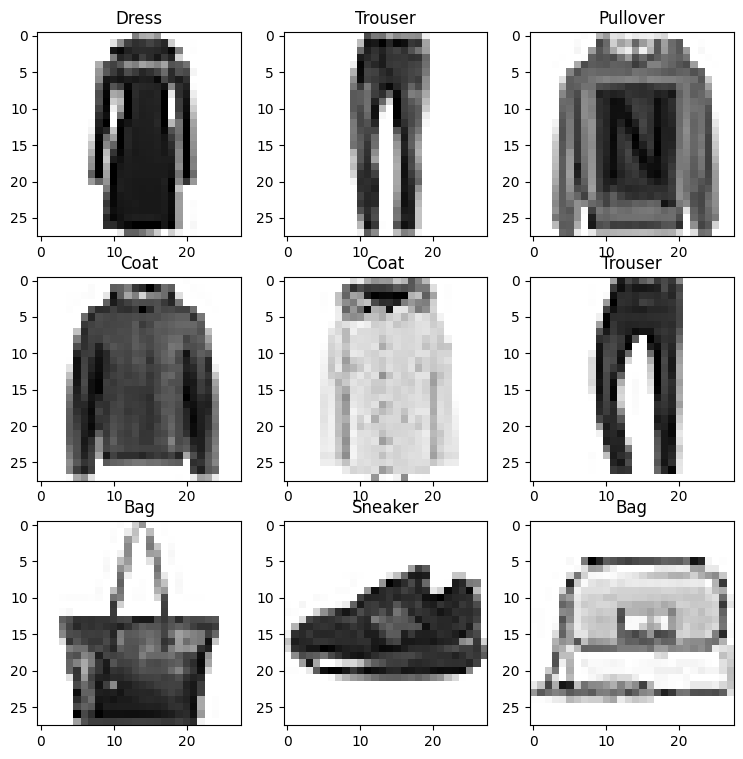

In [28]:
fig = plt.figure(figsize=(9, 9))

rows, cols = 3, 3

for i in range(1, rows * cols + 1):
  rand_idx = torch.randint(0, len(training_data), (1,)).item()
  fig.add_subplot(rows, cols, i)
  feat, label = training_data[rand_idx]
  plt.title(training_data.classes[label])
  plt.imshow(feat.squeeze(), cmap=plt.cm.gray_r)

In [33]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(dataset=training_data, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(dataset=testing_data, batch_size=32, shuffle=False)

In [43]:
len(training_data.classes)

10

In [46]:
class FashionModel(nn.Module):
  def __init__(self, hidden_layers = 10):
    super().__init__()

    self.seq = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=hidden_layers),
        nn.Linear(in_features=hidden_layers, out_features=10)
    )
  def forward(self, x):
    return self.seq(x)

In [51]:
model = FashionModel()

In [59]:
model.eval()
with torch.inference_mode():
  logits = model(training_data[0][0]).squeeze()


logits

tensor([ 0.4506,  0.0224, -0.1043,  0.4497,  0.1692,  0.0659,  0.2494,  0.1252,
         0.2652, -0.3583])